## Processing of the Moana hindcast waterlevel along the coastline

This notebook contains the code used to process the Moana waterlevel data along the coastline.
Unlike the tidal gauge data, the hindcast data do not need despiking and hence this notebook is quite short.

For memory usage reasons, we only analyse one point at a time and results of the analysis at each point are stored to drive as they were being processed. When all points had been processed, the whole of the processed data were reloaded and concatenated together in a single final file.

In [1]:
# Data manipulation imports
import xarray as xr
import pandas as pd
import numpy as np

# Datetime object manipulation imports
from datetime import datetime
from matplotlib.dates import date2num

# File system interaction imports
import os
from glob import glob
import copy

# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline

# Data analysis imports
import toto
from toto.filters.lanczos_filter import lanczos_filter
from scipy.stats import linregress

# Data storge import
import dill as pickle

/home/metocean/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First, we define a function that does the whole waterlevel analysis.

In [2]:
def do_waterlevel_analysis(df_in, lat, cutoff=30, dt=1, constit='auto'):
    """
    Analyses the total water level contained in the 'elev' field of the dataframe df.
    The analysis includes extracting trend, tides, monthly mean sea level, storm surge
    and the remaining residuals.
    Inputs:
      - df_in: A Pandas Series containing the total water level data.
      - lat: The latitude of the location where the data were collected.
      - cutoff: The cutoff period to use to extract the storm surge in hours.
      - dt: The time resolution of the timeseries in hours. Default is 30 hours.
      - consist: UTide parameter that select the tidal constituents to extract.
           Default is 'auto' which should mean all.
    Outputs:
      - A Pandas DataFrame that contains all the extracted fields.
    """

    # Turn the input series into a dataframe whose colum 'elev' contains
    # the raw water level data.
    df = copy.deepcopy(df_in).rename('elev').to_frame()
    
    # Detrending but don't think there is much to detrend
    # Before detrending we store the position of all the gaps
    print('\tStoring NaNs position')
    f = np.where(np.isnan(df['elev'].values) == 1)
    
    # Get the detrended time series
    print('\tDetrending')
    df['et'] = df['elev']
    # Step 1: Store non nan data
    not_nan_ind = ~pd.isna(df['et'])
    x =  date2num(df['et'][not_nan_ind].index)
    y = df['et'][not_nan_ind].values
    # Step2: Fit linear curve
    m, b, r_val, p_val, std_err = linregress(x, y)
    # Step3: Store the trend
    df['trend'] = m*date2num(df['et'].index) + b
    # Strep4: Remove trend from data
    df['et'] = df['et'] - df['trend']

    #the tidal analysis
    print('\tTidal analysis')
    constituents = df.TideAnalysis._fit_tides(mag='et',
                                              args={'minimum SNR': 2,
                                                    'trend': False,
                                                   'latitude': lat,
                                                  'constit': constit
                                                    })
    df = pd.concat([df, df.TideAnalysis\
                          ._tidal_elevation_from_constituents(constituents=constituents)\
                          .rename(columns={'tidal_elevation': 'tide'})],
                   axis=1)
    
    # Remove the tides
    df['et'] = df['et'] - df['tide']

    print('\tMonthly mean filtering')
    # Now we extract the mean sea level anomaly using a 30-day running average of the non-tidal residual (Haigh et al. 2014)
    # In order not to loose to much data when gaps exist in the data we allow the running average to return a value
    # as long as half of the data is non-nan
    df['msea'] = (df['et']).rolling(window=int(24*30/dt),
                                    min_periods=int(24*30/2),
                                    center=True).mean()

    # Remove the monthly mean sea level variations
    df['et'] = df['et'] - df['msea']

    # We extract the storm surge using a Lanczos lowpass filter
    # here to avoid loosing too much data we fill gaps that contain up to 3 nans using second order Akima spline interpolation.
    df['ss'] = lanczos_filter(df['et'].interpolate(axis=0, limit=3, limit_area='inside', method='akima', order=2),
                              args={'window':30, 'type':'lanczos lowpas 2nd order'})

    # We subtract the storm surge to get the residuals
    df['res'] = df['et'] - df['ss']
    

    # We subtract that component to what is left of the signal and add the tide back (for the skew surge)
    df['et'] = df['et'] - df['msea'] + df['tide']

    # Get skew surge from tide + storm surge + residuals
    print('\tSkew surge filtering')
    df['et'] = df['res'].interpolate(axis=0, limit=3, limit_area='inside', method='akima', order=2) + df['ss'] + df['tide']
    df = pd.concat([df, df.TideAnalysis.skew_surge(mag='et',
                                                   args={'minimum SNR': 2,
                                                         'trend': False,
                                                         'latitude': lat,
                                                         'constituents':constituents,
                                                         'tide_dt': 60*60,
                                                        })],
                    axis=1)

    # Apply back initial mask
    for key in [k for k in df.keys() if not k in ['tide',
                                                  'skew_surge_magnitude',
                                                  'skew_surge_lag',
                                                  'tidal_elevation_maximum_over_tidal_cycle',
                                                  'tidal_elevation_maximum_time_over_tidal_cycle']]:
        df[key].values[f] = np.nan

    return df, constituents

And we define a function to store the results of the analysis at a point on drive.

In [3]:
def store_data_as_zarr(results, lon, lat, outname):                                                                              
    """
    This function format and stores to drive in zarr format the content
    of a dataframe contain waterlevel analysis data for a single point.
    Inputs:
    - results (Pandas DataFrame): Dataframe object containing waterlevel
                                  analysis data for a single location.
    - lon (float): The longitude of the location of the data.
    - lat (float): The latitude of the location of the data.
    - outname (string): Path where to store the data on drive
    """
    
    # Turn dataframe into xarray dataset and add a "site" dimension
    dset_out = results.to_xarray().drop(['et', 'lat_rho', 'lon_rho']).expand_dims("site")                                        
                                                                                                                                 
    # Set variable encoding/compression                                                                                       
    encoding_params = {'dtype': 'short',                                                                                         
                       'scale_factor': 0.001,                                                                                    
                       '_FillValue':-999.}                                                                                       

    # Add longitude/latitude of point
    dset_out = dset_out.assign({"lon": ("site", [lon]),                                                                          
                                "lat": ("site", [lat])})                                                                         
                                     
    # Set the long names of the variables
    dset_out.elev.attrs.update({'long_name': 'water_level'})                                                                     
    dset_out.trend.attrs.update({'long_name': 'trend'})                                                                          
    dset_out.tide.attrs.update({'long_name': 'tide'})                                                                            
    dset_out.msea.attrs.update({'long_name': 'monthly_sea_level_variation'})                                                     
    dset_out.ss.attrs.update({'long_name': 'storm_surge'})                                                                       
    dset_out.res.attrs.update({'long_name': 'residual'})                                                                         
    dset_out.lon.attrs.update({'long_name': 'longitude'})                                                                        
    dset_out.lat.attrs.update({'long_name': 'latitude'})                                                                         
    dset_out.skew_surge_magnitude.attrs.update({'long_name': 'skew_surge_magnitude'})                                            
    dset_out.skew_surge_lag.attrs.update({'long_name': 'skew_surge_lag'})                                                        
    dset_out.tidal_elevation_maximum_over_tidal_cycle.attrs.update({'long_name': 'tidal_elevation_maximum_over_tidal_cycle'})    
    dset_out.tidal_elevation_maximum_time_over_tidal_cycle.attrs.update({'long_name': 'tidal_elevation_maximum_time_over_tidal_cycle'})                                                                                                                          
    dset_out.total_water_level_maximum_over_tidal_cycle.attrs.update({'long_name': 'total_water_level_maximum_over_tidal_cycle'})                                                                                                                                
                                                                                                                                 
    # Set the units of the variables                                                                                        
    dset_out.elev.attrs.update({'units': 'm'})
    dset_out.trend.attrs.update({'units': 'm'})                                                                                  
    dset_out.tide.attrs.update({'units': 'm'})                                                                                   
    dset_out.msea.attrs.update({'units': 'm'})                                                                                   
    dset_out.ss.attrs.update({'units': 'm'})                                                                                     
    dset_out.res.attrs.update({'units': 'm'})                                                                                    
    dset_out.skew_surge_magnitude.attrs.update({'units': 'm'})                                                                   
    dset_out.skew_surge_lag.attrs.update({'units': 'hours'})                                                                     
    dset_out.tidal_elevation_maximum_over_tidal_cycle.attrs.update({'units': 'm'})
    # Skip this one as this is generated as part of the timestamp encoding on the xarray side
    #dset_out.tidal_elevation_maximum_time_over_tidal_cycle.attrs.update({'units': 'ISO8601 timestamp'})
    dset_out.total_water_level_maximum_over_tidal_cycle.attrs.update({'units': 'm'})                                             
                               
    # Write to drive in zarr format
    dset_out.to_zarr(outname,
                     encoding={'elev': encoding_params,
                               'trend': encoding_params,                                                                         
                               'tide': encoding_params,                                                                          
                               'msea': encoding_params,                                                                          
                               'ss': encoding_params,                                                                            
                               'res': encoding_params,                                                                           
                               'skew_surge_magnitude': encoding_params,                                                          
                               'tidal_elevation_maximum_over_tidal_cycle': encoding_params,                                      
                               'total_water_level_maximum_over_tidal_cycle': encoding_params,                                    
                               'skew_surge_lag': encoding_params})                
             


Before starting the processing, we need to identify the location of all the coastline points. We do so by loading the first frame of data and building a mask. All points for which the value of the sea surface height is nan are considered to be land and all other points being consider to be ocean point. A costaline point is any ocean point which has at least one neighbouring point on land.

In [4]:
# Build land mask form first frame
mask = np.where(np.isnan(xr.open_zarr('/data/ssh/zeta_199401_chunked_zarr/').isel(time=0).zeta.values),
                True,
                False)

# Return the coordinates of the coastline points according to mask
def extract_coastline(mask):                                                                                                      
    points = []                                                                                                                   
    for i in range(1,mask.shape[0]-1):                                                                                            
        for j in range(1,mask.shape[1]-1):                                                                                        
            if not mask[i,j]:                                                                                                     
                if True in mask[i-1:i+2, j-1:j+2]:                                                                                
                    points.append([i,j])                                                                                          
    return points

coastline = extract_coastline(mask)

<ipython-input-4-c430fcf7810b>:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  mask = np.where(np.isnan(xr.open_zarr('/data/ssh/zeta_199401_chunked_zarr/').isel(time=0).zeta.values),


We plot the location of the identified coastline points.

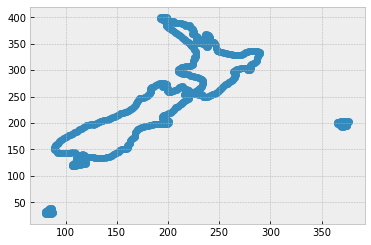

In [5]:
plt.scatter([c[1] for c in coastline], [c[0] for c in coastline])

As the Moana data is stored on our drive as monthly files, we used xarray to load each slice in a dataset object and concatenate them along the time dimension. We also make sure we dont have duplicated timestamps.

In [6]:
moana_data = xr.concat([xr.open_zarr(d) for d in sorted(glob('/data/ssh/zeta_*_chunked_zarr/'))],
                       dim='time').rename({'zeta':'elev'})

_, index = np.unique(moana_data['time'], return_index=True)
moana_data = moana_data.isel(time=index)

<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  moana_data = xr.concat([xr.open_zarr(d) for d in sorted(glob('/data/ssh/zeta_*_chunked_zarr/'))],
<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicit

<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  moana_data = xr.concat([xr.open_zarr(d) for d in sorted(glob('/data/ssh/zeta_*_chunked_zarr/'))],
<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicit

<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  moana_data = xr.concat([xr.open_zarr(d) for d in sorted(glob('/data/ssh/zeta_*_chunked_zarr/'))],
<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicit

<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  moana_data = xr.concat([xr.open_zarr(d) for d in sorted(glob('/data/ssh/zeta_*_chunked_zarr/'))],
<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicit

<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  moana_data = xr.concat([xr.open_zarr(d) for d in sorted(glob('/data/ssh/zeta_*_chunked_zarr/'))],
<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicit

<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  moana_data = xr.concat([xr.open_zarr(d) for d in sorted(glob('/data/ssh/zeta_*_chunked_zarr/'))],
<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicit

<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  moana_data = xr.concat([xr.open_zarr(d) for d in sorted(glob('/data/ssh/zeta_*_chunked_zarr/'))],
<ipython-input-6-5230bbbf345d>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicit

/home/metocean/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [7]:
moana_data

<xarray.Dataset>
Dimensions:  (time: 210217, eta_rho: 467, xi_rho: 397)
Coordinates:
  * time     (time) datetime64[ns] 1994-01-01 1994-01-01T01:00:00 ... 2017-12-25
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    lat_rho  (time, eta_rho, xi_rho) float64 dask.array<chunksize=(745, 234, 199), meta=np.ndarray>
    lon_rho  (time, eta_rho, xi_rho) float64 dask.array<chunksize=(745, 234, 199), meta=np.ndarray>
    elev     (time, eta_rho, xi_rho) float32 dask.array<chunksize=(94, 59, 100), meta=np.ndarray>

Now we loop over all the points of the coastline and do the water level analysis. We store the results of the analysis in terms of timeseries in zarr format. We also store the extracted tidal constituents as raw binary object using dill (imported as pickle).

In [ ]:
output_folder = '/data/ssh/tmp'

for [ieta,irho] in coastline:
    outpath = os.path.join(output_folder,
                           'sks-%i_%i.zarr'%(ieta, irho))
    if not os.path.isdir(outpath):
        os.mkdir(outpath)
        print("Processing coast point", ieta, irho)
        p_data = moana_data.isel(eta_rho=ieta, xi_rho=irho)

        res, constituents =\
            do_waterlevel_analysis(df_in=p_data.to_dataframe()['elev'],
                                   lat=float(p_data.isel(time=0).lat_rho.values),
                                   cutoff=30,
                                   dt=1,
                                   constit='auto')

        with open(output_folder,
                  'constituents-%i_%i.pckl'%(ieta, irho), 'wb') as fout:
            pickle.dump(const, fout)
        
        try: 
            os.rmdir(outpath)
            store_data_as_zarr(res,
                               lon=float(p_data.isel(time=0).lon_rho.values),
                               lat=float(p_data.isel(time=0).lat_rho.values),
                               outname=outpath)
            print(ieta, irho, "Done")
        except:
            print("Failed", outpath)
            raise

Now that all the coast points have been processed and the results stored in separate files we reload them and assemble them into a single dataset which we store on drive in zarr format for future usage.

In [ ]:
full_dataset =\
    xr.concat([xr.open_zarr(os.path.join(output_folder,
                                         'sks-'+str(p[0])+'_'+str(p[1])+'.zarr/')) for p in coastline],
              dim='site')

In [ ]:
full_dataset.to_zarr(os.path.join(output_folder,
                                  'moana_coast_processed/'))